In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def open_csv(filename):
    df = pd.read_csv(filename, header=None, sep='\t')
    cols = [(line[0], line[1], line[2]) for _, line in df.iterrows()]
    return [c[0] for c in cols], [c[1] for c in cols], [c[2] for c in cols]
    
train_user_ids, train_movie_ids, train_scores = open_csv('./u1.base')
test_user_ids, test_movie_ids, test_scores = open_csv('./u1.test')

train_user_ids = np.array(train_user_ids) - 1 # id1 -> id0
train_movie_ids = np.array(train_movie_ids) - 1
test_user_ids = np.array(test_user_ids) - 1
test_movie_ids = np.array(test_movie_ids) - 1

In [17]:
# 数据处理
u_len = max(np.max(train_user_ids), np.max(test_user_ids)) + 1
i_len = max(np.max(train_movie_ids), np.max(test_movie_ids)) + 1

train_mtx = np.zeros((u_len, i_len), dtype=np.int)
for u, i, c in zip(train_user_ids, train_movie_ids, train_scores):
    train_mtx[u][i] = c
    
test_mtx = np.array(train_mtx, dtype=np.int)
for u, i, c in zip(test_user_ids, test_movie_ids, test_scores):
    test_mtx[u][i] = c

k = 200
P = np.random.random((k, u_len))
Q = np.random.random((k, i_len))

In [18]:
# 训练超参数
lr = 1e-3
gamma = 0.4

epoches = 200
show_epoch = 1

$$
pred_{ui} = P_u^TQ_i \\
Loss = \frac{1}{\#R}\sum[(pred_{ui} - R_{ui})^2 + \gamma(\|P_u\|^2 + \|Q_i\|^2)] \\
\frac{\partial Loss}{\partial P} = \frac{2}{\#R}[(pred_{ui} - R_{ui})Q_i + \gamma P_u] \\
\frac{\partial Loss}{\partial Q} = \frac{2}{\#R}[(pred_{ui} - R_{ui})P_u + \gamma Q_i] \\
$$

In [19]:
def calc_loss_acc(P, Q, mtx):
    pred = np.clip(np.round(P.T.dot(Q)).astype(np.int), 1, 5)
    
    num, loss, acc = 0, 0, 0
    for u in range(mtx.shape[0]):
        for i in range(mtx.shape[1]):
            if mtx[u][i] != 0:
                num += 1
                loss += (pred[u, i] - mtx[u, i]) ** 2 + gamma * ((np.linalg.norm(P[:, u]) ** 2 + np.linalg.norm(Q[:, i]) ** 2))
                acc += 1 if mtx[u][i] == pred[u][i] else 0

    return loss / num, acc / num

calc_loss_acc(P, Q, test_mtx)

(56.882860029947, 0.21201)

In [20]:
train_losses, train_accs = [], []
test_losses, test_accs = [], []

for epoch in range(epoches):
    for u, i in zip(train_user_ids, train_movie_ids):
        P[:, u] = P[:, u] - 2 * lr * (((P[:, u].T.dot(Q[:, i]) - train_mtx[u, i]) * Q[:, i]) + gamma * P[:, u])
        Q[:, i] = Q[:, i] - 2 * lr * (((P[:, u].T.dot(Q[:, i]) - train_mtx[u, i]) * P[:, u]) + gamma * Q[:, i])
        
    train_loss, train_acc = calc_loss_acc(P, Q, train_mtx)
    test_loss, test_acc = calc_loss_acc(P, Q, test_mtx)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    if epoch % show_epoch == 0:
        print('Epoch: %d, train_loss: %.4f, test_loss: %.4f, train_acc: %.4f, test_acc: %.4f' % (epoch, train_loss, test_loss, train_acc, test_acc))
    

Epoch: 0, train_loss: 21.7898, test_loss: 21.8056, train_acc: 0.1116, test_acc: 0.1130
Epoch: 1, train_loss: 18.5780, test_loss: 18.6706, train_acc: 0.1251, test_acc: 0.1263
Epoch: 2, train_loss: 16.5203, test_loss: 16.6562, train_acc: 0.1321, test_acc: 0.1327
Epoch: 3, train_loss: 14.8732, test_loss: 15.0427, train_acc: 0.1390, test_acc: 0.1395
Epoch: 4, train_loss: 13.4833, test_loss: 13.6799, train_acc: 0.1482, test_acc: 0.1482
Epoch: 5, train_loss: 12.2840, test_loss: 12.4984, train_acc: 0.1611, test_acc: 0.1604
Epoch: 6, train_loss: 11.2954, test_loss: 11.5112, train_acc: 0.1769, test_acc: 0.1751
Epoch: 7, train_loss: 10.4703, test_loss: 10.6858, train_acc: 0.1943, test_acc: 0.1915
Epoch: 8, train_loss: 9.7814, test_loss: 9.9914, train_acc: 0.2099, test_acc: 0.2062
Epoch: 9, train_loss: 9.2076, test_loss: 9.4105, train_acc: 0.2276, test_acc: 0.2232
Epoch: 10, train_loss: 8.7297, test_loss: 8.9231, train_acc: 0.2423, test_acc: 0.2374
Epoch: 11, train_loss: 8.3233, test_loss: 8.5119

Epoch: 96, train_loss: 4.0299, test_loss: 4.0864, train_acc: 0.3453, test_acc: 0.3435
Epoch: 97, train_loss: 4.0246, test_loss: 4.0806, train_acc: 0.3453, test_acc: 0.3436
Epoch: 98, train_loss: 4.0189, test_loss: 4.0744, train_acc: 0.3454, test_acc: 0.3437
Epoch: 99, train_loss: 4.0138, test_loss: 4.0688, train_acc: 0.3453, test_acc: 0.3437
Epoch: 100, train_loss: 4.0084, test_loss: 4.0630, train_acc: 0.3455, test_acc: 0.3438
Epoch: 101, train_loss: 4.0029, test_loss: 4.0572, train_acc: 0.3455, test_acc: 0.3438
Epoch: 102, train_loss: 3.9979, test_loss: 4.0520, train_acc: 0.3455, test_acc: 0.3438
Epoch: 103, train_loss: 3.9932, test_loss: 4.0468, train_acc: 0.3457, test_acc: 0.3439
Epoch: 104, train_loss: 3.9882, test_loss: 4.0416, train_acc: 0.3458, test_acc: 0.3441
Epoch: 105, train_loss: 3.9835, test_loss: 4.0365, train_acc: 0.3458, test_acc: 0.3441
Epoch: 106, train_loss: 3.9791, test_loss: 4.0317, train_acc: 0.3457, test_acc: 0.3440
Epoch: 107, train_loss: 3.9744, test_loss: 4.02

Epoch: 191, train_loss: 3.7815, test_loss: 3.8193, train_acc: 0.3473, test_acc: 0.3458
Epoch: 192, train_loss: 3.7804, test_loss: 3.8181, train_acc: 0.3473, test_acc: 0.3458
Epoch: 193, train_loss: 3.7793, test_loss: 3.8169, train_acc: 0.3472, test_acc: 0.3458
Epoch: 194, train_loss: 3.7782, test_loss: 3.8157, train_acc: 0.3473, test_acc: 0.3458
Epoch: 195, train_loss: 3.7770, test_loss: 3.8144, train_acc: 0.3473, test_acc: 0.3458
Epoch: 196, train_loss: 3.7761, test_loss: 3.8134, train_acc: 0.3473, test_acc: 0.3458
Epoch: 197, train_loss: 3.7750, test_loss: 3.8122, train_acc: 0.3473, test_acc: 0.3459
Epoch: 198, train_loss: 3.7739, test_loss: 3.8110, train_acc: 0.3473, test_acc: 0.3458
Epoch: 199, train_loss: 3.7727, test_loss: 3.8098, train_acc: 0.3473, test_acc: 0.3459


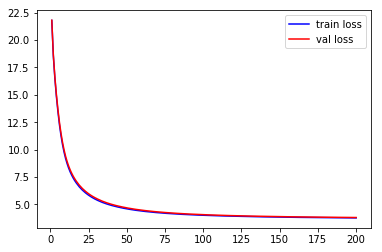

In [21]:
plot_range = range(1, len(train_accs) + 1)

plt.plot(plot_range, train_losses, 'b')
plt.plot(plot_range, test_losses, 'r')
plt.legend(['train loss', 'val loss'])
plt.savefig('./lab_3_1_1.pdf')
plt.show()

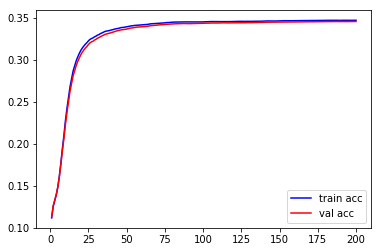

In [22]:
plt.plot(plot_range, train_accs, 'b')
plt.plot(plot_range, test_accs, 'r')
plt.legend(['train acc', 'val acc'])
plt.savefig('./lab_3_1_2.pdf')
plt.show()

In [24]:
print(u_len, i_len)

943 1682
